In [1]:
import os
import scipy as sp
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import constants
import re
import subprocess

## Create a series of structures (data files) for different lattice constants

## Silicon

## Germanium

In [2]:
# Germanium

print("Current Working Directory " , os.getcwd())
#Uncomment the following line and write the directory you want to save the files
os.chdir("/Users/User/Desktop/Computational_physics/Molecular_dynamics/project4")
print("Current Working Directory " , os.getcwd())


ar=np.arange(3.,7.0,0.05)

for a in ar:
    A0=np.array([[a,0,0],[0,a,0],[0,0,a]])
# diamond    
    basis=[[0.125,0.125,0.125],[0.625,0.625,0.125],[0.625,0.125,0.625],[0.875,0.375,0.375],[0.125,0.625,0.625],[0.375,0.875,0.375],[0.375,0.375,0.875],[0.875,0.875,0.875]]
# sc
#    basis=[[0.,0.,0.]]
# bcc
#    basis=[[0.,0.,0.],[0.5,0.5,0.5]]
# fcc
#    basis=[[0.,0.,0.],[0.5,0.5,0.0],[0.5,0.0,0.5],[0.0,0.5,0.5]]
    x=np.zeros((np.shape(basis)[0],3))
    for i in range(np.shape(basis)[0]):
        x[i]=np.dot(basis[i],np.transpose(A0))
    filename='Ge'+str(f'{a:1.2f}')+'.fcc.data'   
    with open(filename, 'w') as f:
        f.write('#Lammps Data File')
        f.write('\n')
        f.write('\n')
        lines = [str(np.shape(basis)[0]),' atoms']
        for l in lines:
            f.write(l)
        f.write('\n')
        f.write('1 atom types')
        f.write('\n')
        f.write('\n')
        lines = ['0.0 ',str(a),' xlo xhi']
        for l in lines:
            f.write(l)
        f.write('\n')
        lines = ['0.0 ',str(a),' ylo yhi']
        for l in lines:
            f.write(l)
        f.write('\n')
        lines = ['0.0 ',str(a),' zlo zhi']
        for l in lines:
            f.write(l)
        f.write('\n')
        f.write('\n')
        f.write('Masses')
        f.write('\n')
        f.write('\n')
        f.write('1 28.0855 #Si')
        f.write('\n')
        f.write('\n')
        f.write('Atoms # atomic')
        f.write('\n')
        f.write('\n')
        for j in np.arange(np.shape(basis)[0]):
            lines=[str(j+1),' 1 ',str(x[j][0]),' ',str(x[j][1]),' ',str(x[j][2])]
            for l in lines:
                f.write(l)
            f.write('\n')
    f.close()

Current Working Directory  /Users/User/Desktop/Computational_physics/Molecular_dynamics/lammps01
Current Working Directory  /Users/User/Desktop/Computational_physics/Molecular_dynamics/project4


## Main code

In [3]:
# extract filenames to be changed inside the in.lammps file
# and lattice contant values

filenames = []
lattice_constants = []
for file in os.listdir('.'):
    if (file.endswith('.data')) & (file != 'germanium.data'):
        filenames.append(file)
        lattice_constants.append(float(file[2:6]))

lattice_constants = np.array(lattice_constants)

In [4]:
energies = []
for filename in filenames:
    # change file to be run next
    with open('in.lammps', 'r') as f:
        lines = f.readlines()
    lines[7] = f'read_data {filename}\n'
    with open('in.lammps', 'w') as f:
        f.writelines(lines)
    
    # run lmp -in in.lammps > result.txt in terminal
    subprocess.run('lmp_serial -in in.lammps > result.txt', shell=True, check=True)
    
    # open result file and extract energy
    with open('result.txt', 'r') as f:
        result = f.readlines()
    energy = float(result[-5][20:-2])
    energies.append(energy)


# Delete all used .data files
for filename in filenames:
    if os.path.exists(filename):
        os.remove(filename)

energies = np.array(energies)
N_atoms = len(basis)

In [5]:
# sort arrays for easier handling
sorted_indices = np.argsort(lattice_constants)
# Apply the sorting
lattice_constants = lattice_constants[sorted_indices]
volumes = lattice_constants**3
energies = energies[sorted_indices]

In [6]:
# estimate optimum lattice constant
min_index = np.where(energies == min(energies))[0][0]
vols = volumes[min_index - 7:min_index + 7]
ens = energies[min_index -7:min_index + 7]

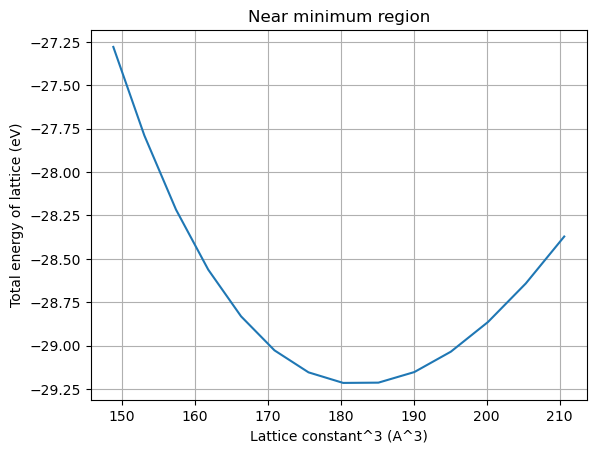

In [7]:
plt.plot(vols, ens)
plt.ylabel('Total energy of lattice (eV)')
plt.xlabel('Lattice constant^3 (A^3)')
plt.grid()
plt.title('Near minimum region')
plt.show()

#### Murnaghan Fit

In [8]:
def murn(v,v0,e0,b0,bP):
    nrg=e0+b0*v/(bP*(bP-1))*(bP*(1-v0/v)+(v0/v)**bP-1)
    return nrg
ev2J=constants.physical_constants['electron volt-joule relationship'][0]

#### Fit Volume vs Energy data (Volume in $Angstrom^3$, Energy in eV)

In [9]:
popt, pcov = curve_fit(murn, vols, ens,[18,-3.55,70,1.1])
print('Bulk Modulus in GPa=',(popt[2]*ev2J/1E-30)/1E9)
pcov

Bulk Modulus in GPa= 76.30044334544442


array([[ 1.10357424e-04, -9.89892920e-07,  1.33693768e-06,
        -1.45667267e-04],
       [-9.89892920e-07,  1.51859078e-07, -1.08021352e-07,
         2.78750717e-06],
       [ 1.33693768e-06, -1.08021352e-07,  1.38870013e-07,
        -4.30143088e-06],
       [-1.45667267e-04,  2.78750717e-06, -4.30143088e-06,
         2.72260370e-04]])

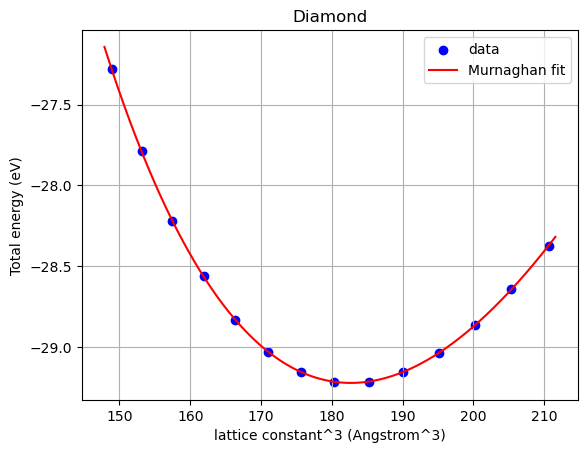

In [12]:
plt.scatter(vols,ens,color='blue',label = 'data')
vout=np.arange(vols[0]-1,vols[-1]+1,0.1)
nrgOut=murn(vout,popt[0],popt[1],popt[2],popt[3])
plt.plot(vout,nrgOut,color='red', label = 'Murnaghan fit')
plt.xlabel('lattice constant^3 (Angstrom^3)')
plt.ylabel('Total energy (eV)')
plt.title('Diamond')
plt.legend()
plt.grid()
plt.show()

In [11]:
print('Optimum values:\n')
print(f'Lattice constant: a={(popt[0])**(1/3)}(A)\n\nCohesive energy: E0={popt[1]/N_atoms}(eV)\n\nBulk Modulus: B={popt[2]*ev2J/1E-30/1E9}(GPa)')

Optimum values:

Lattice constant: a=5.673918044316601(A)

Cohesive energy: E0=-3.6527191334227154(eV)

Bulk Modulus: B=76.30044334544442(GPa)


### Uncomment the basis of the structure to be run and restart and run all cells

# EOF